In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
from scipy import interp
from scipy.stats import fisher_exact 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix, make_scorer
from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
import os, sys 
import warnings
warnings.filterwarnings("ignore")

In [2]:
src_dir = os.path.normpath(os.path.join(os.getcwd(), 'src/util'))
sys.path.insert(0, src_dir)
src_dir_model = os.path.normpath(os.path.join(os.getcwd(), 'Analysis_model'))
sys.path.insert(0, src_dir_model)

In [9]:
import FileIO as fio
import PCA_Analysis as pca
import RF_Analysis_Binary as rfb
from util import collapse_taxonomic_contents_df
import Formatting as fmt

# Random Forest to classify Healthy/Disease in all datasets 

In [5]:
def results2df(results, dataset, n_ctrl, n_case, n_features):
    resultsdf = pd.DataFrame(data = np.array((results["mean_fpr"], 
                                              results["mean_tpr"])).T,
                             columns = ["mean_fpr", "mean_tpr"])
    resultsdf["roc_auc"] = results["roc_auc"]
    resultsdf["fisher_p"] = results["fisher_p"]
    resultsdf["accuracy"] = results["accurancy"]
    resultsdf["F1_score"] = results["f1"]
    
    resultsdf["dataset"] = dataset
    resultsdf["H_smpls"] = n_ctrl
    resultsdf["dis_smpls"] = n_case
    resultsdf["num_features"] = n_features
    
    return resultsdf

In [6]:
datadir = "data/clean_tables"
dfdict = fio.read_dfdict_data(datadir)

Reading datasets...
liv_zhang
cdi_youngster
ibd_willing
crc_baxter
noncdi_schubert
ob_turnbaugh
crc_wang
hiv_dinh
ob_zupancic
cdi_schubert
par_scheperjans
t1d_mejialeon
hiv_lozupone
art_scher
ob_goodrich
ob_zhu
hiv_noguerajulian
asd_son
t1d_alkanani
crc_zeller
edd_singh
ibd_gevers
ob_ross
cdi_vincent
crc_chen
nash_wong
asd_kang
ibd_morgan
nash_zhu
ibd_papa

Reading datasets... Finished.


## Data Information

In [15]:
stats = pd.read_csv("data/analysis_results/datasets_info.txt", sep='\t')
stats['dataset'] = stats['dataset']\
    .replace('edd_singh', 'cdi_singh')\
    .replace('noncdi_schubert', 'cdi_schubert2')
_, dataset_order = fmt.get_dataset_order(stats)
stats['dataset'] = stats['dataset'].astype('category')
stats['dataset'].cat.set_categories(dataset_order, inplace=True)
stats = stats.sort_values(by='dataset')

labeldict = fmt.get_labeldict(stats['dataset'])
stats['dataset_label'] = stats['dataset'].apply(lambda x: labeldict[x])

stats['dataset'] = stats['dataset'].astype(str)
stats = stats.sort_values(by='dataset')
data_information = stats[['dataset_label', 'year', 'controls', 'N_ctrl', 
                          'cases', 'N_dis', 'med_reads', 'sequencer', 
                          'region', 'citation']].reset_index(drop=True)
data_information

,dataset_label,year,controls,N_ctrl,cases,N_dis,med_reads,sequencer,region,citation
0,"Scher 2013, ART",2013,H,28,"PSA, RA",86,2194.0,454,V1-V2,\cite{ra-littman}
1,"Kang 2013, ASD",2013,H,20,ASD,19,1345.0,454,V2-V3,\cite{asd-kb}
2,"Son 2015, ASD",2015,H,44,ASD,59,4777.0,Miseq,V1-V2,\cite{asd-son}
3,"Schubert 2014, CDI",2014,H,154,CDI,93,4897.0,454,V3-V5,\cite{cdi-schubert}
4,"Schubert 2014, nonCDI",2014,H,154,nonCDI,89,4903.0,454,V3-V5,\cite{cdi-schubert}
5,"Singh 2015, EDD",2015,H,82,EDD,201,2585.0,454,V3-V5,\cite{edd-singh}
6,"Vincent 2013, CDI",2013,H,25,CDI,25,2526.5,454,V3-V5,\cite{cdi-vincent}
7,"Youngster 2014, CDI",2014,H,4,CDI,19,15081.0,Miseq,V4,\cite{cdi-youngster}
8,"Baxter 2016, CRC",2016,H,172,CRC,120,9913.5,Miseq,V4,\cite{crc-baxter}
9,"Chen 2012, CRC",2012,H,22,CRC,21,1152.0,454,V1-V3,\cite{crc-xiang}


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

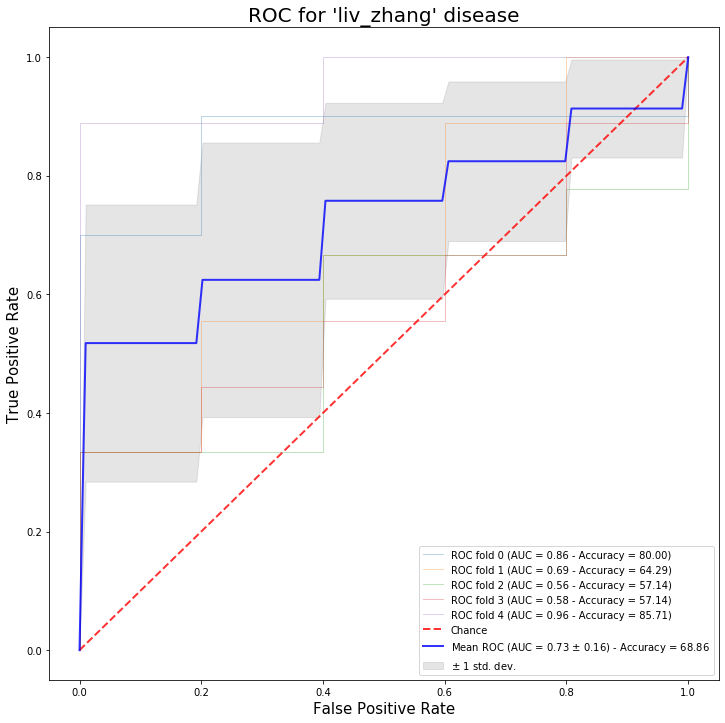

  3%|██▊                                                                                | 1/30 [00:02<01:24,  2.90s/it]

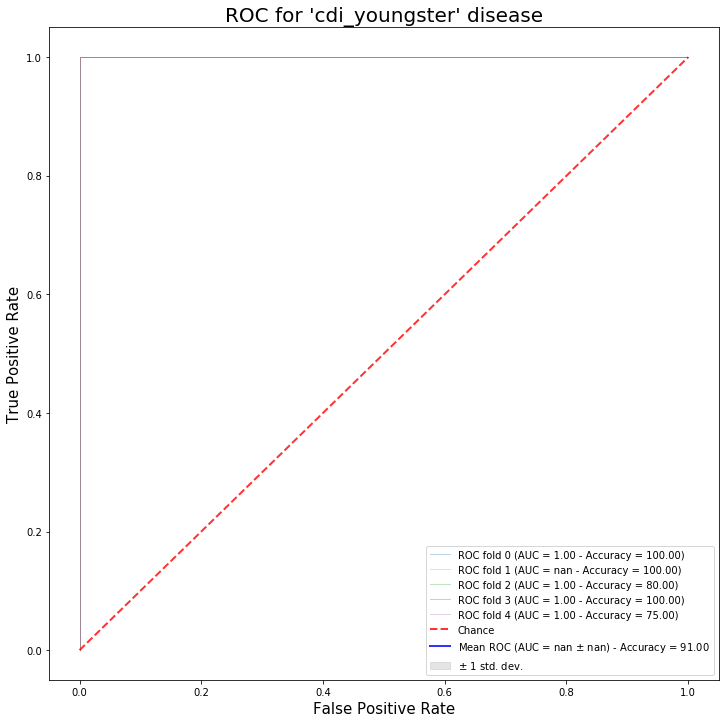

  7%|█████▌                                                                             | 2/30 [00:05<01:19,  2.82s/it]

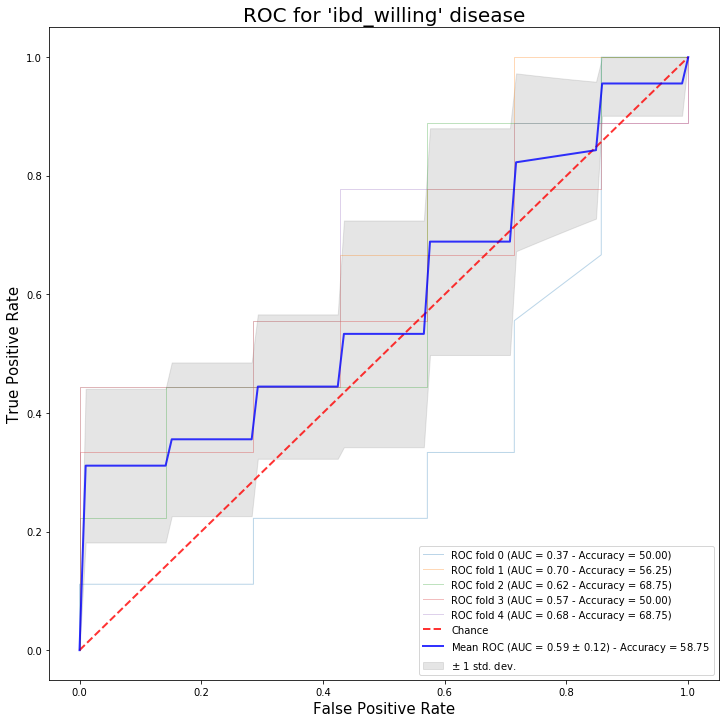

 10%|████████▎                                                                          | 3/30 [00:08<01:17,  2.86s/it]

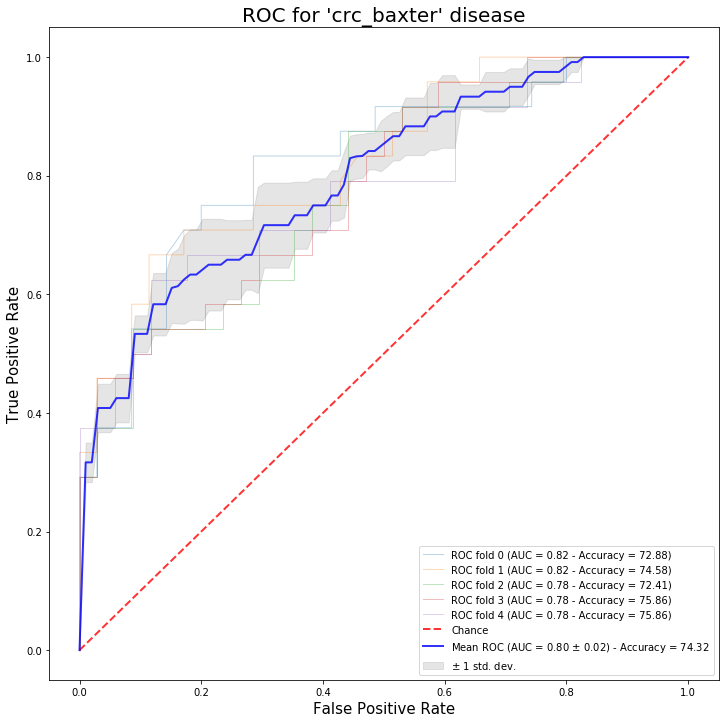

 13%|███████████                                                                        | 4/30 [00:13<01:28,  3.41s/it]

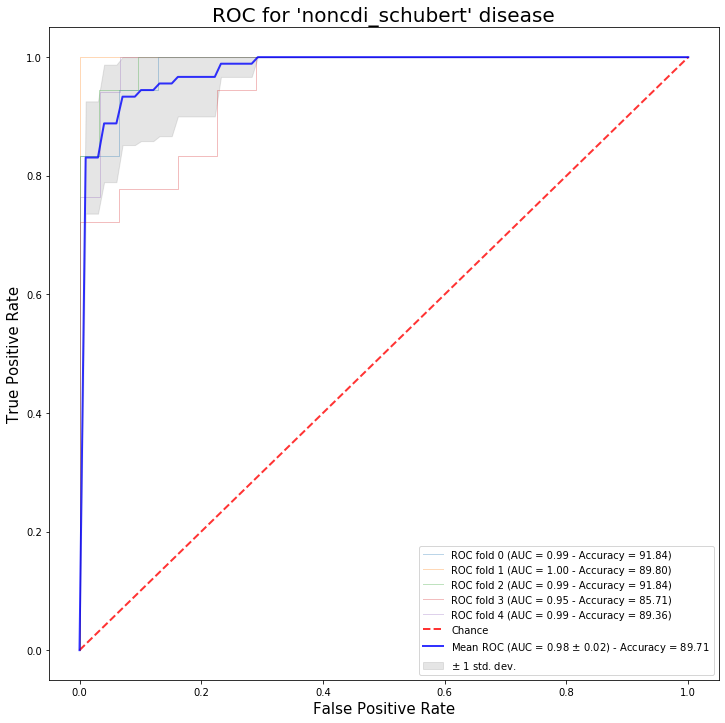

 17%|█████████████▊                                                                     | 5/30 [00:16<01:25,  3.44s/it]

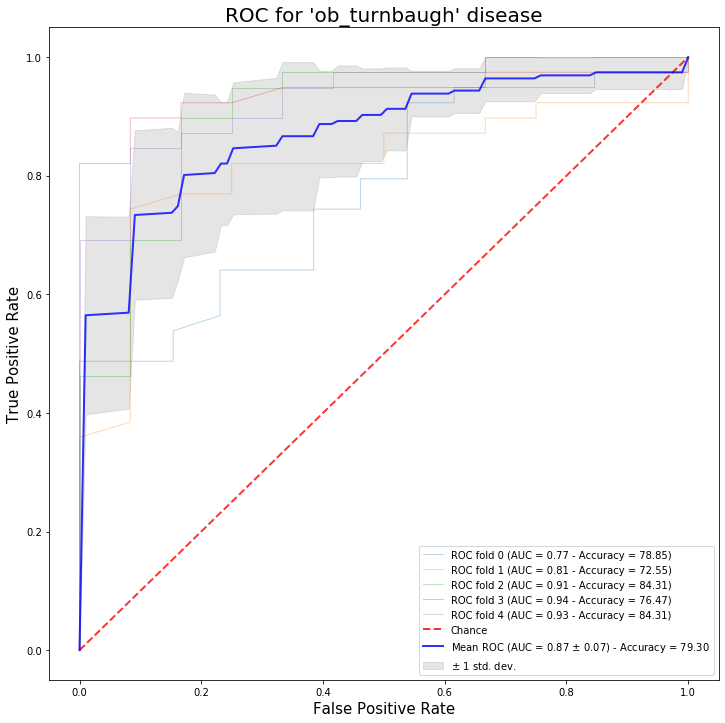

 20%|████████████████▌                                                                  | 6/30 [00:20<01:24,  3.54s/it]

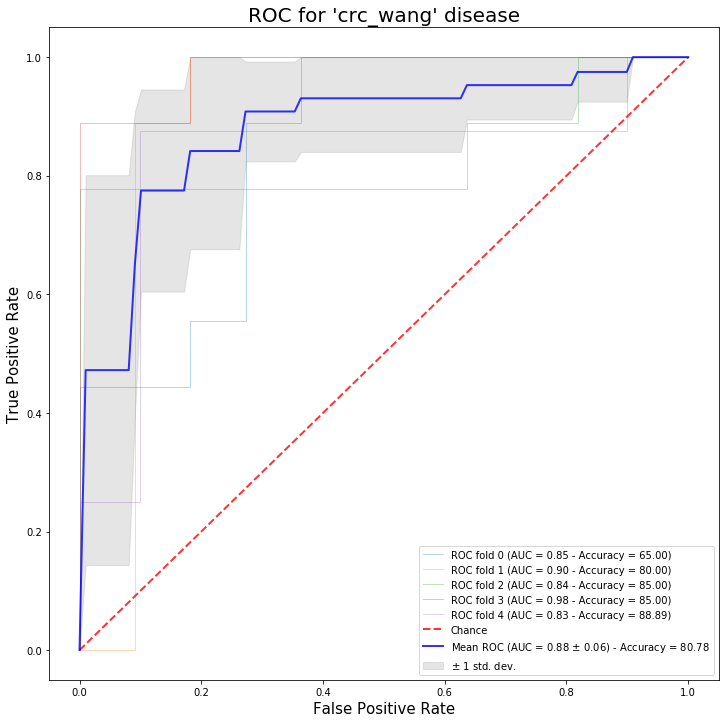

 23%|███████████████████▎                                                               | 7/30 [00:23<01:17,  3.36s/it]

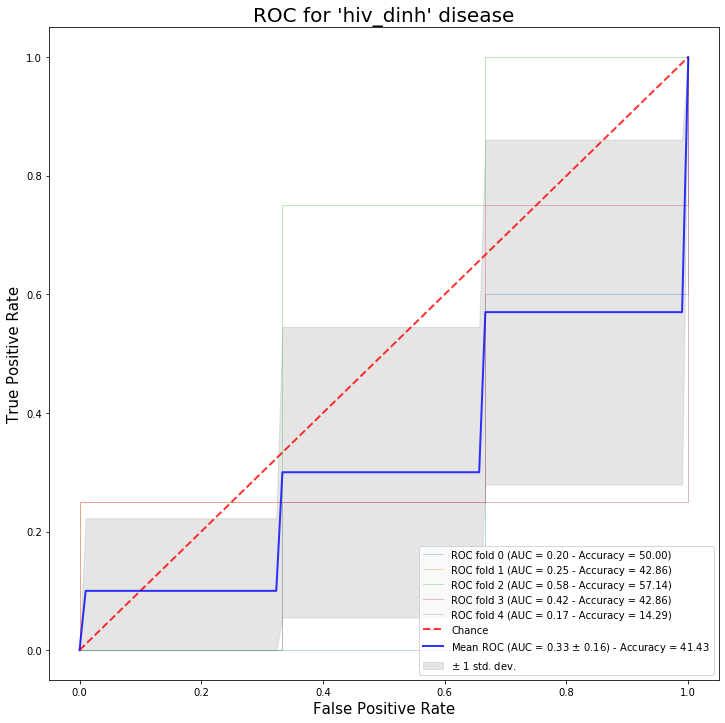

 27%|██████████████████████▏                                                            | 8/30 [00:26<01:10,  3.19s/it]

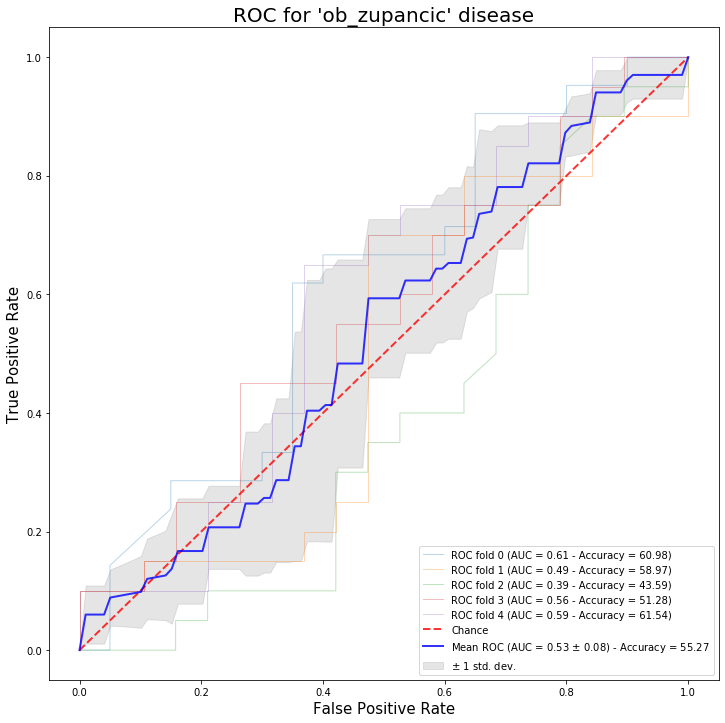

 30%|████████████████████████▉                                                          | 9/30 [00:29<01:08,  3.27s/it]

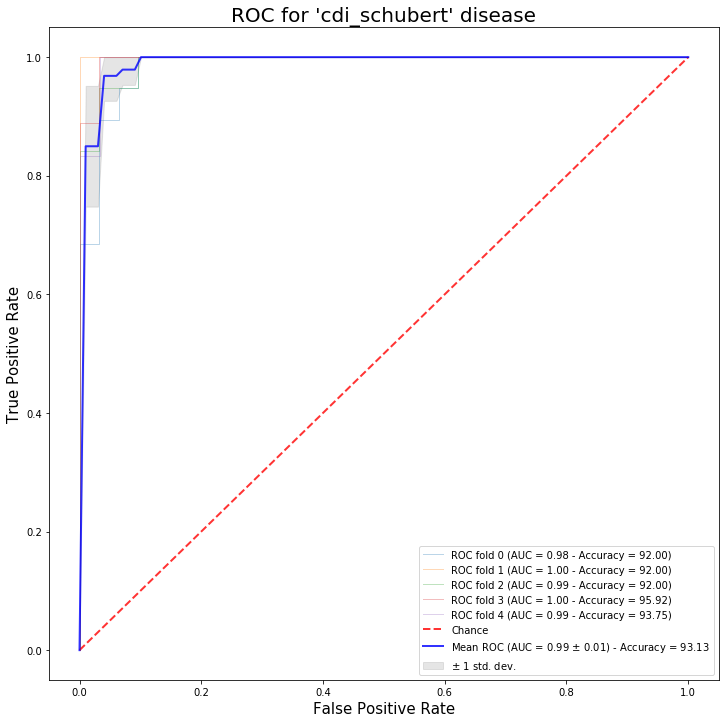

 33%|███████████████████████████▎                                                      | 10/30 [00:33<01:06,  3.33s/it]

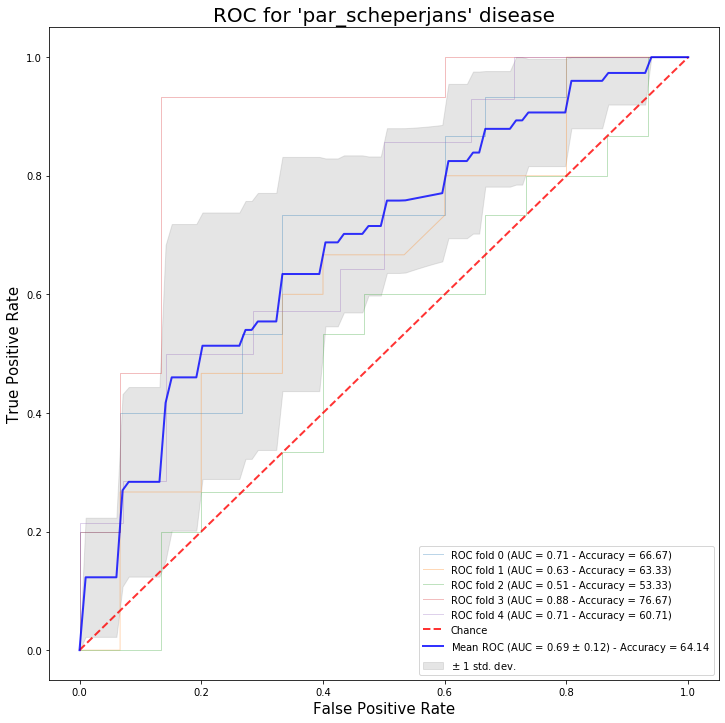

 37%|██████████████████████████████                                                    | 11/30 [00:36<01:03,  3.32s/it]

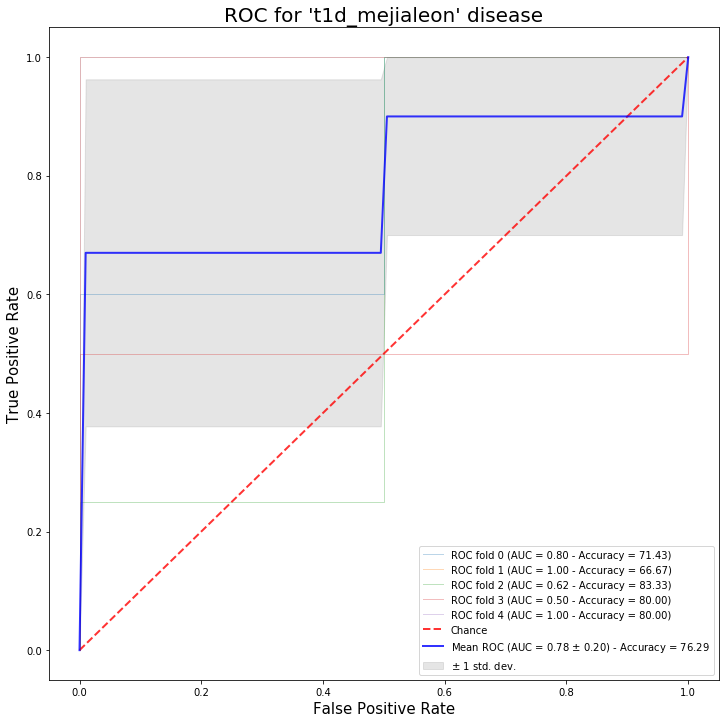

 40%|████████████████████████████████▊                                                 | 12/30 [00:39<00:56,  3.14s/it]

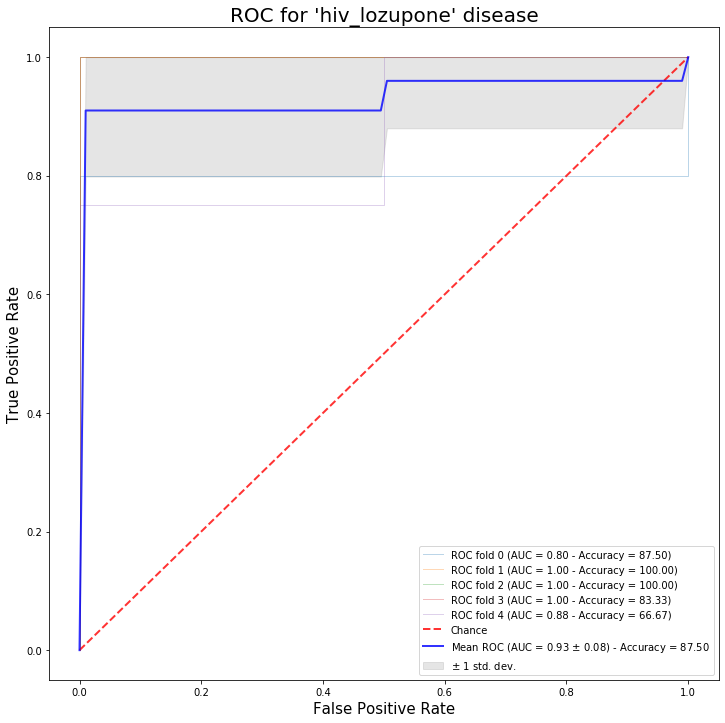

 43%|███████████████████████████████████▌                                              | 13/30 [00:41<00:51,  3.03s/it]

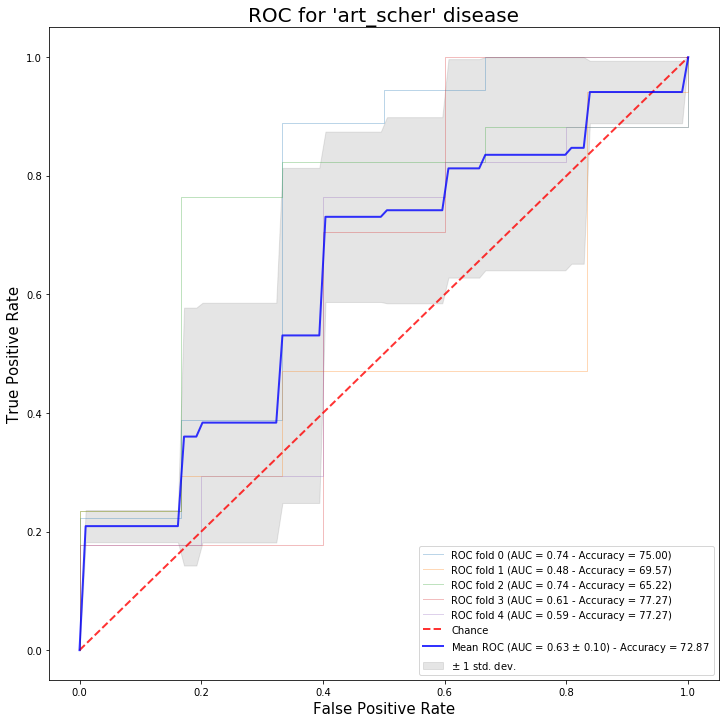

 47%|██████████████████████████████████████▎                                           | 14/30 [00:44<00:48,  3.05s/it]

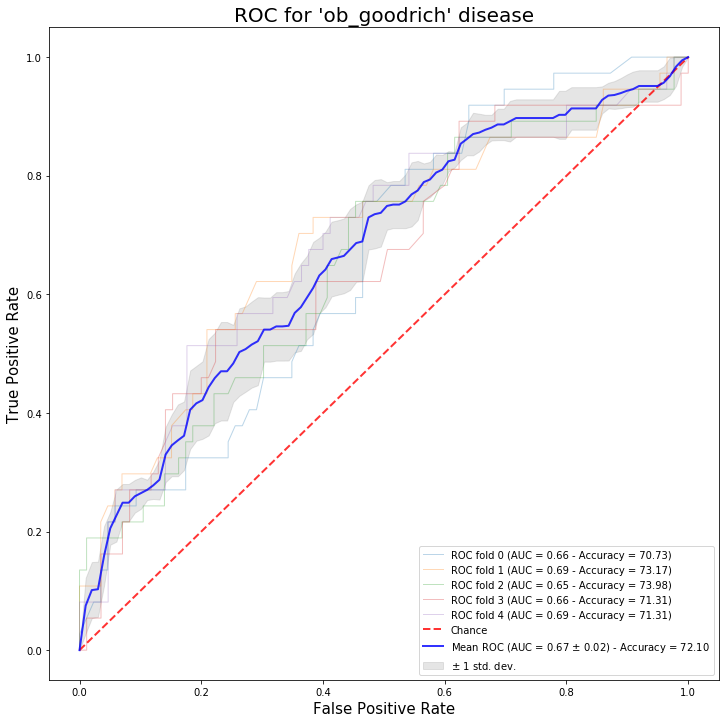

 50%|█████████████████████████████████████████                                         | 15/30 [00:53<01:08,  4.57s/it]

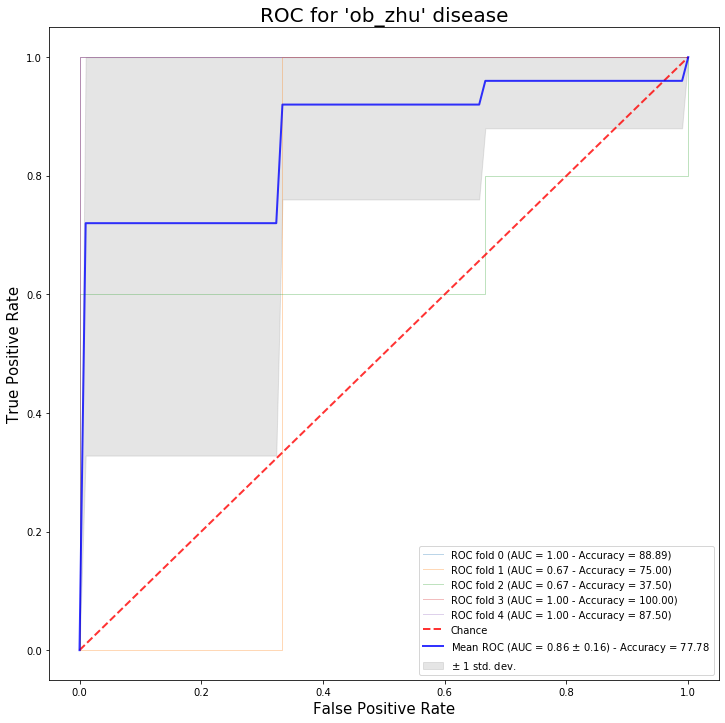

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:55<00:56,  4.03s/it]

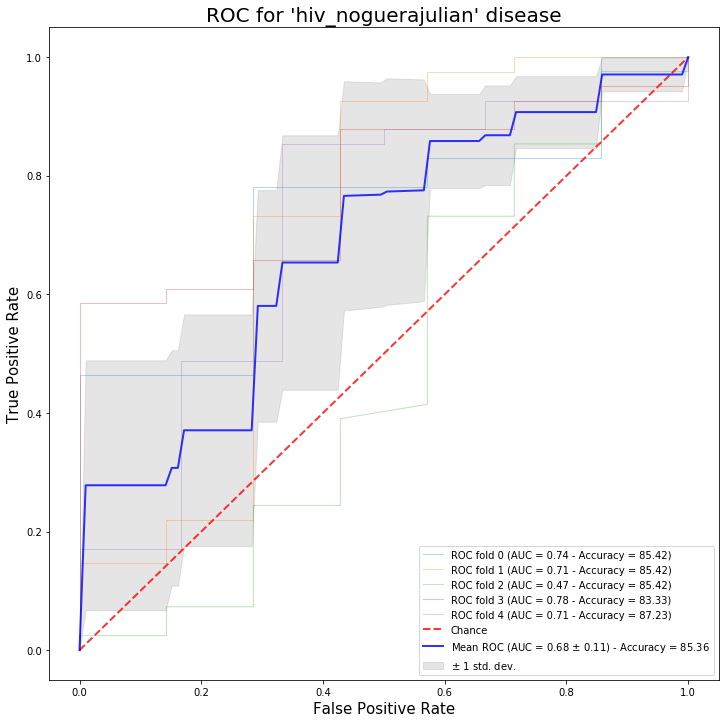

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:59<00:52,  4.04s/it]

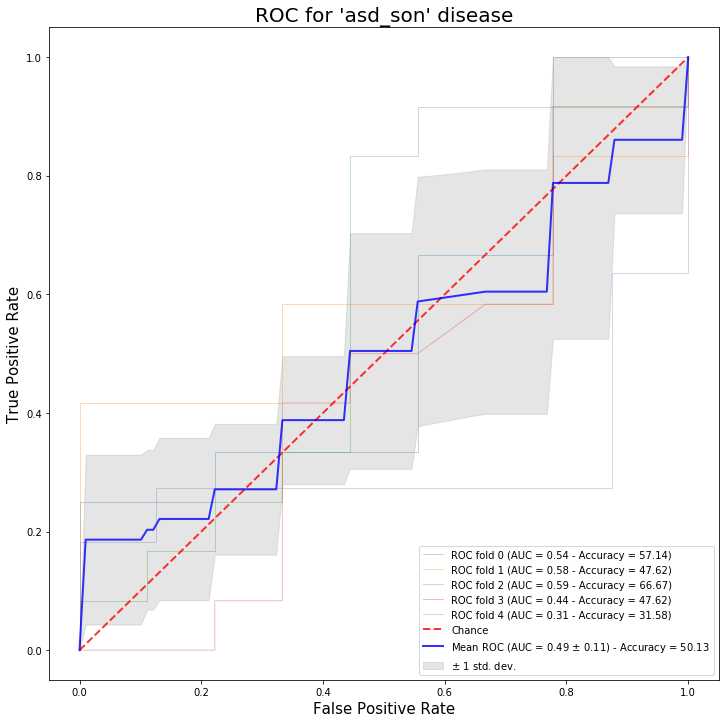

 60%|█████████████████████████████████████████████████▏                                | 18/30 [01:03<00:45,  3.77s/it]

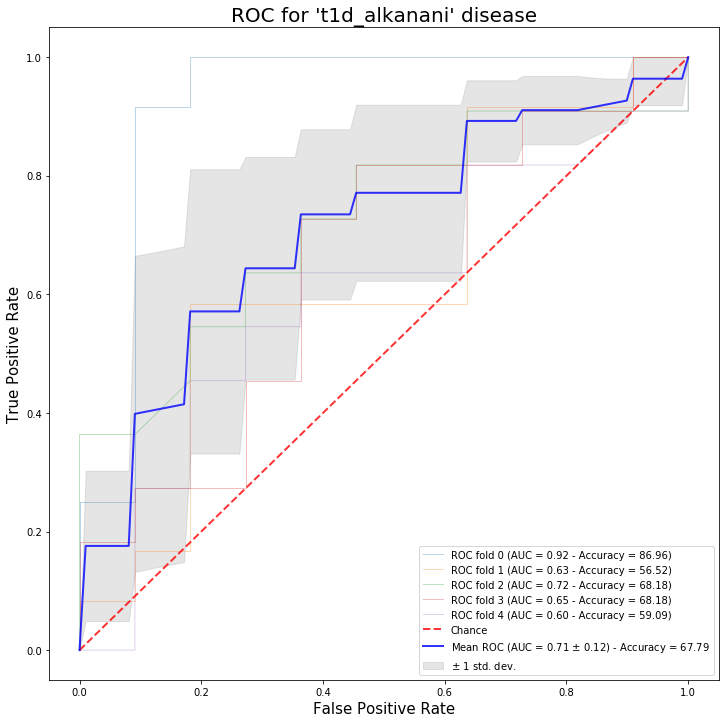

 63%|███████████████████████████████████████████████████▉                              | 19/30 [01:06<00:39,  3.62s/it]

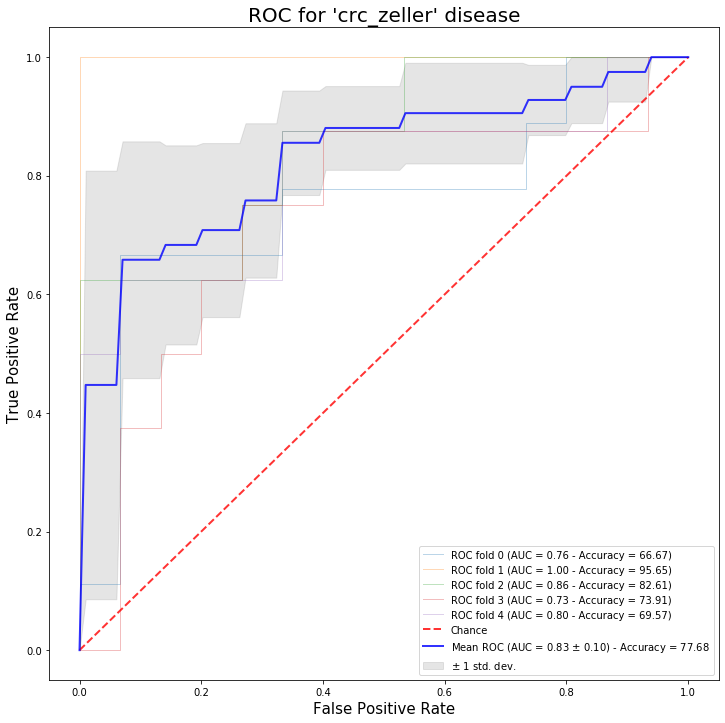

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [01:09<00:35,  3.58s/it]

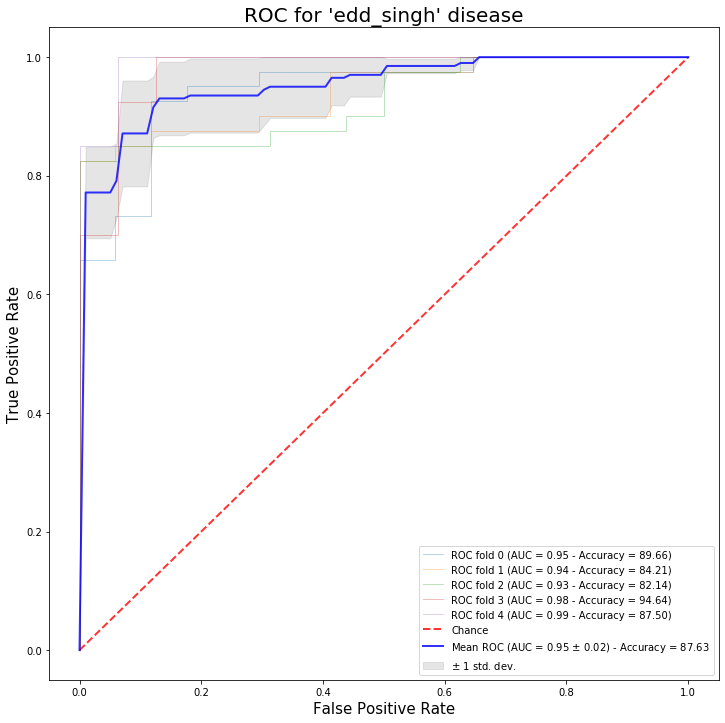

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [01:13<00:32,  3.62s/it]

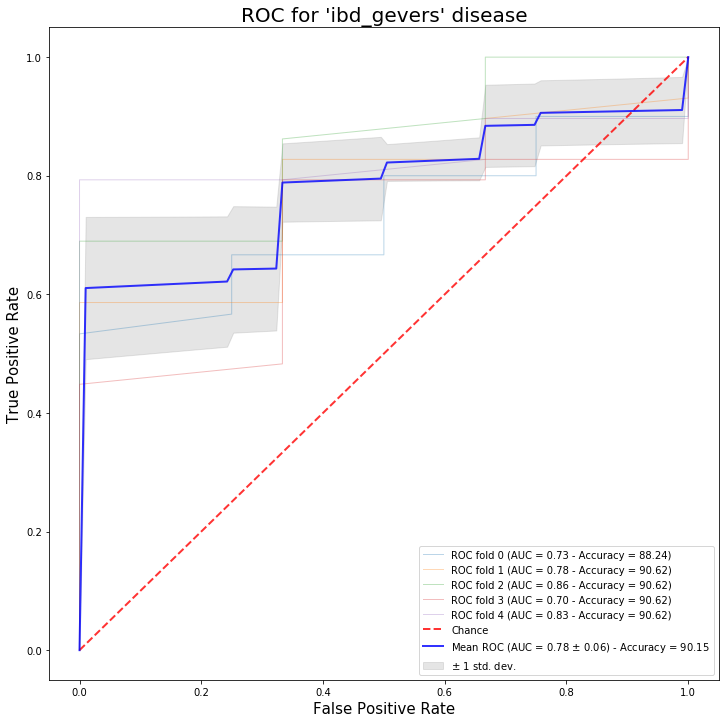

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [01:16<00:28,  3.52s/it]

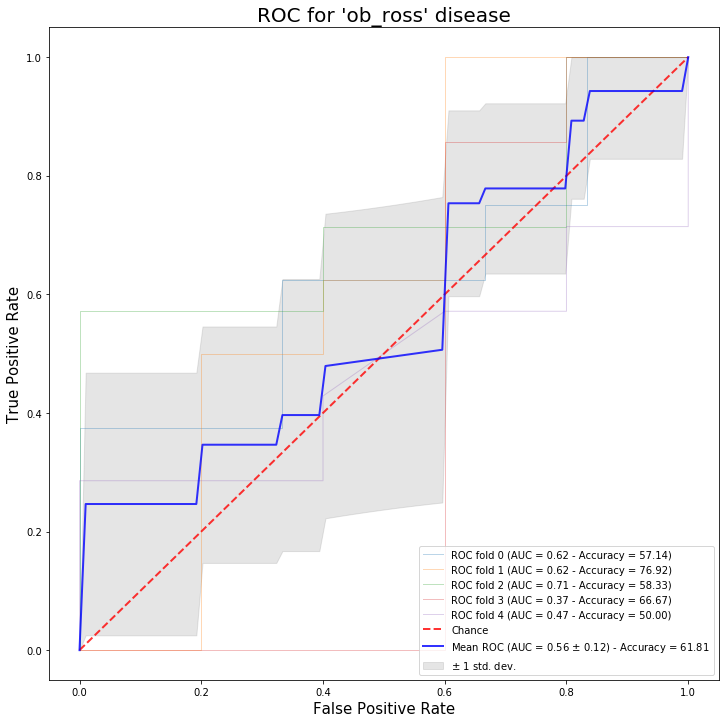

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [01:19<00:23,  3.33s/it]

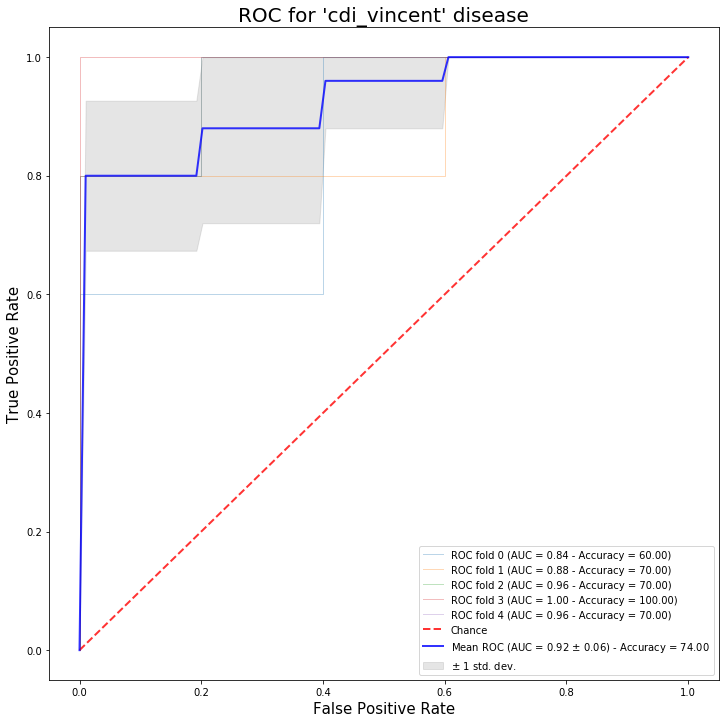

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [01:22<00:19,  3.18s/it]

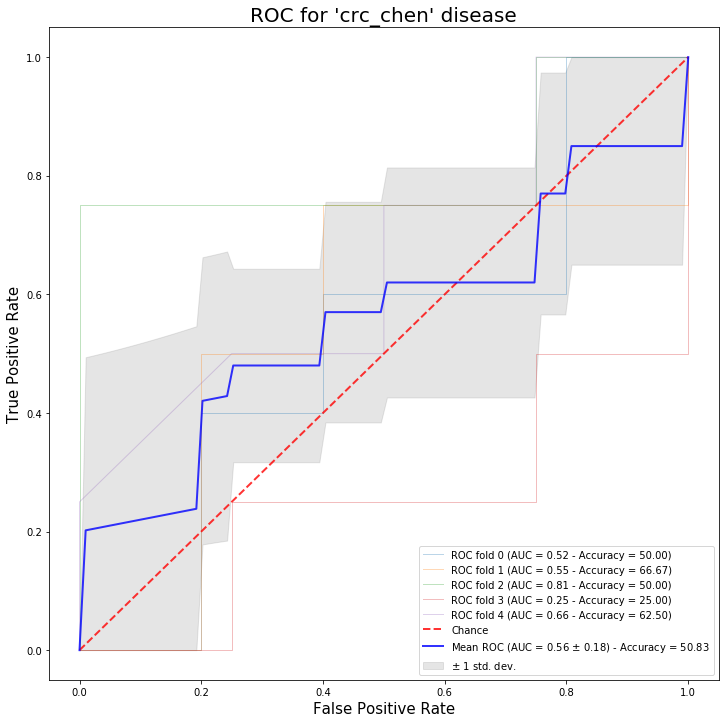

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [01:25<00:15,  3.06s/it]

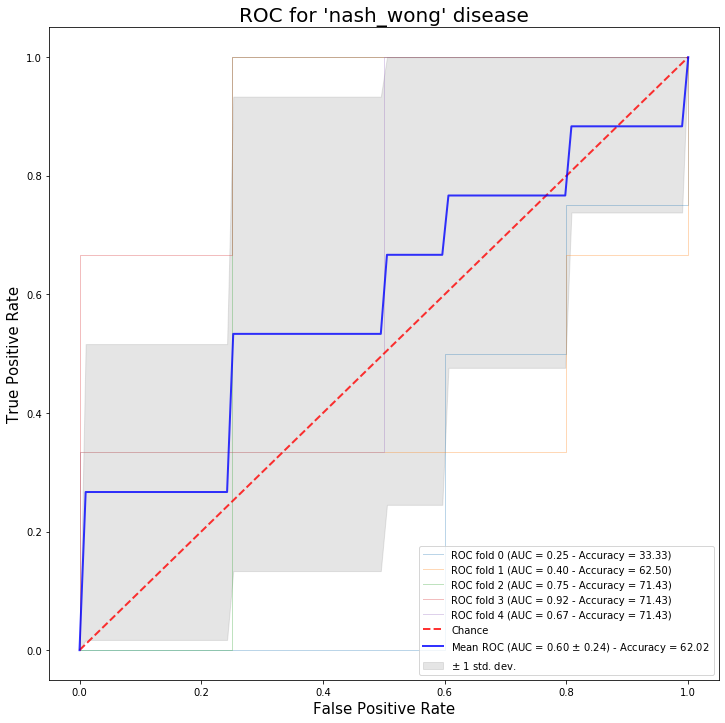

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [01:28<00:11,  2.96s/it]

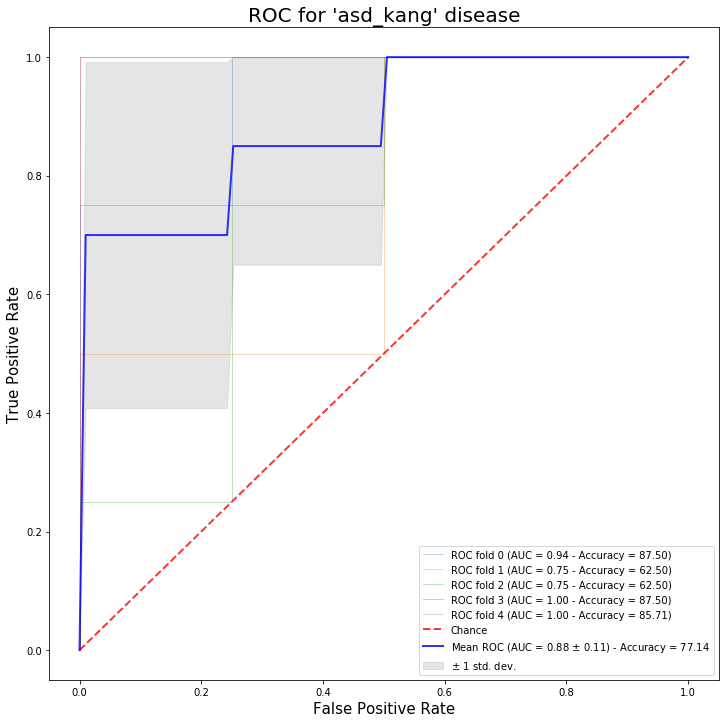

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [01:30<00:08,  2.90s/it]

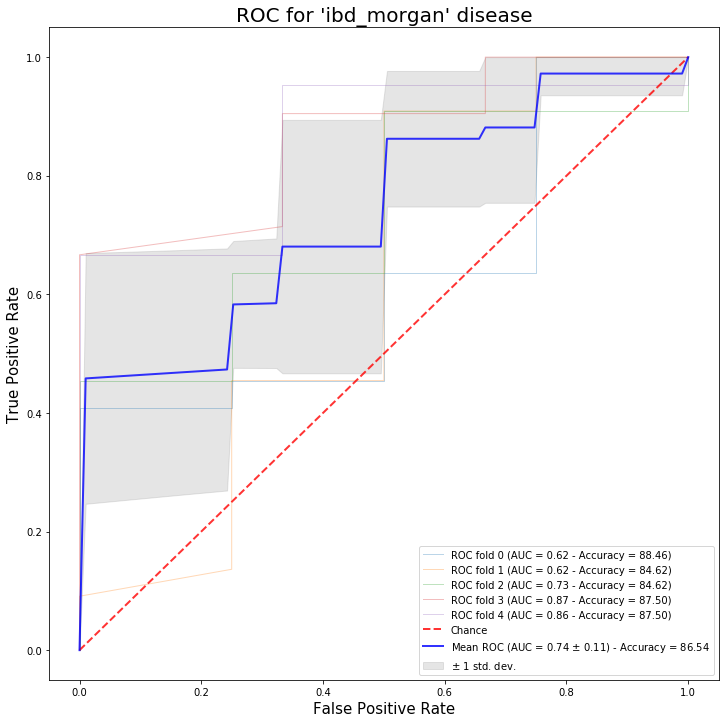

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [01:33<00:05,  2.93s/it]

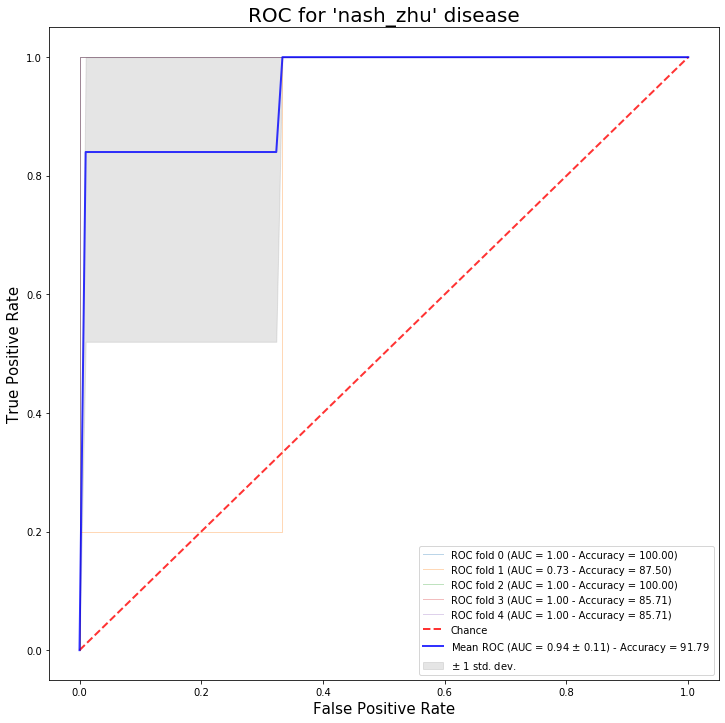

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [01:36<00:02,  2.88s/it]

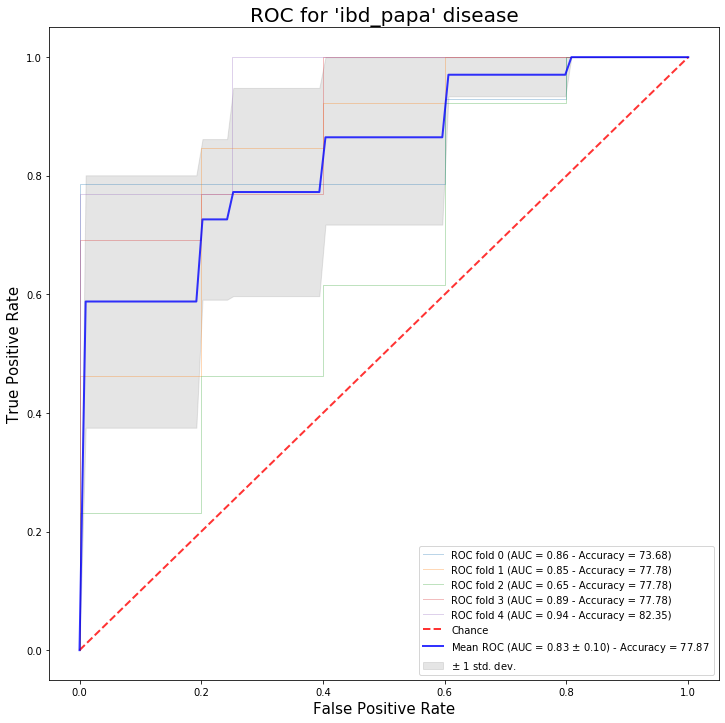

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:39<00:00,  2.90s/it]


In [16]:
tidyresults = []
with tqdm(total = len(dfdict.keys())) as pbar:
    for dataset in dfdict.keys():
        time.sleep(0.1)
        df = dfdict[dataset]["df"]
        meta = dfdict[dataset]["meta"]
        
        df = collapse_taxonomic_contents_df(df, "genus")
        
        classes_list = fio.get_classes(meta, dataset)
        H_smpls, dis_smpls = fio.get_samples(meta, classes_list)
        
        rf, X, y = rfb.prep_rf(df, H_smpls, dis_smpls, random_state = 42)
        results = rfb.RF_SKF(rf, X, y, num_cv = 5, random_state = 42, plot = True, disease=dataset)
        resultsdf = results2df(results, dataset, len(H_smpls), len(dis_smpls), df.shape[1])
        tidyresults.append(resultsdf)
        pbar.update()

In [19]:
tidydf = pd.concat(tidyresults, ignore_index=True)
tidydf.to_csv("rf_results.csv", sep='\t', index=False)

## Analysis of results

In [22]:
dataset_info = pd.read_csv("data/analysis_results/datasets_info.txt", sep='\t')
dfauc = pd.read_csv("rf_results.csv", sep='\t')
dfauc = dfauc\
    .replace('edd_singh', 'cdi_singh')\
    .replace('noncdi_schubert', 'cdi_schubert2')
dataset_info = dataset_info\
    .replace('edd_singh', 'cdi_singh')\
    .replace('noncdi_schubert', 'cdi_schubert2')
_, dataset_order = fmt.get_dataset_order(dataset_info)

In [23]:
auc_lst = []
dfauc = dfauc[['dataset', 'roc_auc', 'accuracy', 'F1_score']].drop_duplicates()
for d, auc, acc, f1 in zip(dfauc['dataset'], dfauc['roc_auc'], dfauc['accuracy'], dfauc['F1_score']):
    auc_lst.append([auc, acc, f1, d, d.split('_')[0]])
tidy_auc = pd.DataFrame(data=auc_lst, 
                        columns = ['AUC', 'Accuracy', 'F1_score', 'label', 'disease'])

Text(0, 0.5, '')

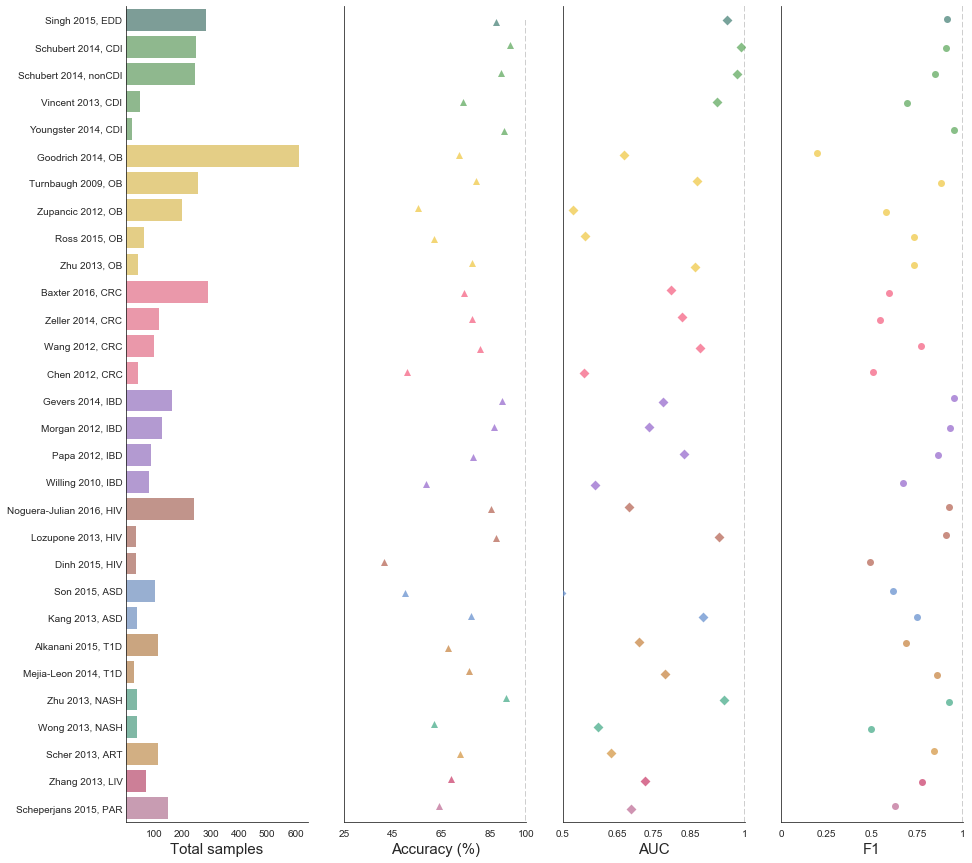

In [29]:
import seaborn as sns
import matplotlib.gridspec as gridspec

disease_colors = fmt.get_disease_colors()
diseases = set([i.split('_')[0] + '_' for i in dataset_order])
colors = {}

for d in diseases:
    dis_datasets = [i for i in dataset_order if i.startswith(d)]
    colors.update({i:j for i, j in zip(dis_datasets,
        len(dis_datasets)*[sns.light_palette(disease_colors[d[:-1]])[-1]])})
    colors['cdi_singh'] = disease_colors['edd']
labeldict = fmt.get_labeldict(dataset_order)    
sns.set_style('white', {'ytick.direction': 'in', 'ytick.major.size': 2.0, 
                        'font.size': 'xx-small'})
    
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(1,4)
ax_samplesize = plt.subplot(gs[0])
ax_auc = plt.subplot(gs[2])
ax_acc = plt.subplot(gs[1])
ax_f1 = plt.subplot(gs[3])

sns.barplot(y='dataset', x='total', data=dataset_info, 
            order=dataset_order, ax=ax_samplesize, palette=colors,
            edgecolor='', alpha=.75)
[ax_samplesize.spines[i].set_visible(False) for i in ['right', 'top']]
ax_samplesize.set_xticks([100, 200, 300, 400, 500, 600])
ax_samplesize.set_xticklabels(['100', '200', '300', '400', '500', '600'])
ax_samplesize.xaxis.set_label_position('bottom')
ax_samplesize.set_yticklabels([labeldict[i] for i in dataset_order], rotation=0)
ax_samplesize.set_ylabel('')
ax_samplesize.set_xlabel('Total samples', fontsize=15)

# Plot AUCs 
ax_auc.plot([1, 1], [-0.5, 29.5], color='0.75', linestyle='--')

ax_auc = sns.stripplot(y='label', x='AUC', data=tidy_auc, order=dataset_order, palette=colors,
                  ax=ax_auc, size=7, marker='D', alpha=.75)
ax_auc.set_yticklabels([])
ax_auc.set_xlim([0.5, 1])
ax_auc.set_xticks([0.5, 0.65, 0.75, 0.85, 1])
ax_auc.set_xticklabels([0.5, 0.65, 0.75, 0.85, 1])
ax_auc.xaxis.set_label_position('bottom')
[ax_auc.spines[i].set_visible(False) for i in ['right', 'top']]
ax_auc.set_xlabel('AUC', fontsize=15)
ax_auc.set_ylabel('')

# Plot Accuracy 
ax_acc.plot([100, 100], [0, 100], color='0.75', linestyle='--')

ax_acc = sns.stripplot(y='label', x='Accuracy', data=tidy_auc, order=dataset_order, palette=colors,
                  ax=ax_acc, size=7, marker='^', alpha=.75)
ax_acc.set_yticklabels([])
ax_acc.set_xlim([25, 100])
ax_acc.set_xticks([25, 45, 65, 85, 100])
ax_acc.set_xticklabels([25, 45, 65, 85, 100])
ax_acc.xaxis.set_label_position('bottom')
[ax_acc.spines[i].set_visible(False) for i in ['right', 'top']]
ax_acc.set_xlabel('Accuracy (%)', fontsize=15)
ax_acc.set_ylabel('')

# Plot F1_score
ax_f1.plot([1, 1], [-0.5, 29.5], color='0.75', linestyle='--')

ax_f1 = sns.stripplot(y='label', x='F1_score', data=tidy_auc, order=dataset_order, palette=colors,
                  ax=ax_f1, size=7, alpha=.75)
ax_f1.set_yticklabels([])
ax_f1.set_xlim([0, 1])
ax_f1.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax_f1.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax_f1.xaxis.set_label_position('bottom')
[ax_f1.spines[i].set_visible(False) for i in ['right', 'top']]
ax_f1.set_xlabel('F1', fontsize=15)
ax_f1.set_ylabel('')